In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt


Welcome to JupyROOT 6.20/04


In [2]:

sg40_file = uproot.open("/data/event/final/sg_40ppwax/Events/run_01/tag_1_delphes_events.root") 
sg50_file = uproot.open("/data/event/final/sg_50ppwax/Events/run_01/tag_1_delphes_events.root")
sg60_file = uproot.open("/data/event/final/sg_60ppwax/Events/run_01/tag_1_delphes_events.root")
sg70_file = uproot.open("/data/event/final/sg_70ppwax/Events/run_01/tag_1_delphes_events.root") 
sg80_file = uproot.open("/data/event/final/sg_80ppwax/Events/run_01/tag_1_delphes_events.root")      #########################
sg90_file = uproot.open("/data/event/final/sg_90ppwax/Events/run_01/tag_1_delphes_events.root") 
sg100_file = uproot.open("/data/event/final/sg_100ppwax/Events/run_01/tag_1_delphes_events.root") 
bg_file = uproot.open("/data/event/final/bg_ppaalvll/Events/run_01/tag_1_delphes_events.root")
bg_jet_file = uproot.open("/data/event/final/bgjet_pplvllj/Events/run_01/tag_1_delphes_events.root")

In [3]:
def file_np(file):
    event = [ file["Delphes;1"]["Electron"].array(),
              file["Delphes;1"]["Electron.PT"].array(),
              file["Delphes;1"]["Electron.Eta"].array(),
              file["Delphes;1"]["Electron.Phi"].array(),
              file["Delphes;1"]["Muon"].array(),                #4
              file["Delphes;1"]["Muon.PT"].array(),
              file["Delphes;1"]["Muon.Eta"].array(),
              file["Delphes;1"]["Muon.Phi"].array(),
              file["Delphes;1"]["Photon"].array(),              #8
              file["Delphes;1"]["Photon.PT"].array(),
              file["Delphes;1"]["Photon.Eta"].array(),
              file["Delphes;1"]["Photon.Phi"].array(),
              file["Delphes;1"]["MissingET"].array(),           #12
              file["Delphes;1"]["MissingET.fUniqueID"].array(),   
              file["Delphes;1"]["MissingET.fBits"].array(),
              file["Delphes;1"]["MissingET.MET"].array(),
              file["Delphes;1"]["MissingET.Eta"].array(),
              file["Delphes;1"]["MissingET.Phi"].array(),
              file["Delphes;1"]["Jet"].array(),                 #18
              file["Delphes;1"]["Jet.EhadOverEem"].array(),     
              file["Delphes;1"]["Jet.Mass"].array(),
              file["Delphes;1"]["Event.Number"].array(),
              file["Delphes;1"]["Jet.Tau[5]"].array()
              ]
    
    event = np.expand_dims(event, axis=-1)    ### reshape data
    event = event.transpose((1,0,2))
    event = np.squeeze(event,axis=(2,))
    return event 

feture=['e_Num', 'e_Pt', 'e_Eta', 'ePhi', 'mu_Num', 'mu_Pt', 'mu_Eta', 'mu_Phi', 'a_Num', 'a_Pt', 'a_Eta', 'a_Phi', 'mis_Num', 'mis_ID', 'mis_Fbit', 'mis_Pt', 'mis_Eta', 'mis_Phi', 'jet_Num', 'jet_EhandoverEem', 'jet_Mass', 'Event_Num', 'jet_Tau5' ]

In [4]:
bg_events = file_np(bg_file)
bg_jet_event = file_np(bg_jet_file)
sg40_events = file_np(sg40_file)
sg50_events = file_np(sg50_file)
sg60_events = file_np(sg60_file)
sg70_events = file_np(sg70_file)
sg80_events = file_np(sg80_file)
sg90_events = file_np(sg90_file)
sg100_events = file_np(sg100_file)

In [5]:
me = 0.000511
mu = 0.10566
################################################
def prlen(events):
    print(len(events))

################################################  simple sel (any=? l=1 j>1)
def num_sl(event,lab,num):
    where1 = np.where(event[:,lab]==num)
    return event[where1]

def l_sl(event):
    where1 = np.where(event[:,0]+event[:,4]==1)
    return event[where1]

def j_sl(event):
    where1 = np.where(event[:,18]>0)
    return(event[where1])  

def Ehover(event,sl_jet):
    where=[]
    for i in range(len(event)):
        if np.min(event[i][19])<0.2:
            where.append(i)
            sl_jet.append(np.min(event[i][19]))
    return event[where]   

def soon_sl(event):
    a1 = num_sl(event,8,2)
    b1 = l_sl(a1)
    return b1
def soon_sl_10(event):
    trash=[]
    je1 = j_sl(event)
    eho1= Ehover(je1,trash)
    final_sl = l_sl(eho1)
    return final_sl
        
################################################  maa caculate
def m_aa(events, m, pt1):
    where1=[]   
    for i in range(len(events)):
        p = [0,0,0,0] 
        for j in range(events[i][8]):
            pt = events[i][9][j]   
            eta = events[i][10][j]  
            phi = events[i][11][j]    
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)   ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )     
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(maa)
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        pt1.append(pTaa)
        if 90<maa<110:
            where1.append(i)
    return events[where1]
################################################   pt sl    
def pt_sl(events):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]    
        for j in range(events[i][8]):
            pt = events[i][9][j]    
            eta = events[i][10][j]    
            phi = events[i][11][j]   
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
        pTaa = np.sqrt(p[1]**2 + p[2]**2)    
        if pTaa>50:
              where1.append(i)
    return events[where1]
################################################ mlv caculate
def mvl_sl(events,m):
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(mlv)
##################################################
def MTvl_sl(events,m,pt):
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        m.append(mlv)
        pt.append(ptlv)
##################################################
def j_mass(event):
    a=[]
    for i in range(len(event)):
        where1 = np.where(event[i][19]==np.min(event[i][19]))  
    return event[where1]
        
       
##################################################        
def phi_v(events,phi_list):
    for i in range(len(events)):
        if events[i][0]==1:
            for j in range(len(events[i][3])):
                phi = (events[i][2][j])
                phi_list.append(phi)
        elif events[i][4]==1:
            for j in range(len(events[i][7])):
                phi = events[i][6][j]
                phi_list.append(phi)  
                
def miss_v(events,phi_list):
    for i in range(len(events)):
        for j in range(len(events[i][16])):
            phi = (events[i][17][j])
            phi_list.append(phi)
##################################################  soon drow [i] hist
def soon_draw(events,num,min1,max1,bin_num):
    list1=[]
    for i in range(len(events)):
        if type(events[i][num])==int:
            list1.append(events[i][num])
        else:
            for j in range(len(events[i][num])):
                list1.append(events[i][num][j])
    bins = np.arange(min1,max1,bin_num)
    plt.hist(list1,bins=bins,histtype='step')
    plt.title(feture[num])
    plt.show
    
def soon_drawvs(sg_events40,sg_events50,sg_events60,sg_events70,sg_events80,sg_events90,sg_events100,bg_events,num,min1,max1,bin_num):
    listbg=[]
    list100=[]
    list90=[]
    list80=[]
    list70=[]
    list60=[]
    list50=[]
    list40=[]
    
    for i in range(len(sg_events100)):
        if type(sg_events100[i][num])==int:
            
            list100.append(sg_events100[i][num])
        else:
            for j in range(len(sg_events100[i][num])):
                list100.append(sg_events100[i][num][j])
                
    for i in range(len(sg_events90)):
        if type(sg_events90[i][num])==int:
            list90.append(sg_events90[i][num])
        else:
            for j in range(len(sg_events90[i][num])):
                list90.append(sg_events90[i][num][j]) 

    for i in range(len(sg_events80)):
        if type(sg_events80[i][num])==int:
            list80.append(sg_events80[i][num])
        else:
            for j in range(len(sg_events80[i][num])):
                list80.append(sg_events80[i][num][j])
                
    for i in range(len(sg_events70)):
        if type(sg_events70[i][num])==int:
            list70.append(sg_events70[i][num])
        else:
            for j in range(len(sg_events70[i][num])):
                list70.append(sg_events70[i][num][j]) 
                
    for i in range(len(sg_events60)):
        if type(sg_events60[i][num])==int:
            list60.append(sg_events60[i][num])
        else:
            for j in range(len(sg_events60[i][num])):
                list60.append(sg_events60[i][num][j])
                
    for i in range(len(sg_events50)):
        if type(sg_events50[i][num])==int:
            list50.append(sg_events50[i][num])
        else:
            for j in range(len(sg_events50[i][num])):
                list50.append(sg_events50[i][num][j])
    
    for i in range(len(sg_events40)):
        if type(sg_events40[i][num])==int:
            list40.append(sg_events40[i][num])
        else:
            for j in range(len(sg_events40[i][num])):
                list40.append(sg_events40[i][num][j])    
                
    for i in range(len(bg_events)):
        if type(bg_events[i][num])==int:
            listbg.append(bg_events[i][num])
        else:
            for j in range(len(bg_events[i][num])):
                listbg.append(bg_events[i][num][j])
    bins = np.arange(min1,max1,bin_num)
    plt.hist([list40,list50,list60,list70,list80,list90,list100,listbg] ,histtype='step',density='ture',bins=bins, label=['sg40','sg50','sg60','sg70','sg80','sg90','sg100','bg'],color=['red','yellow','black','green','darkblue','orange','blue','gray'])
    plt.title(feture[num])
    plt.legend()
    plt.show()    
    
################################################### histtype='step',

def soon_drow_m(event10,event50,event80,event100,eventbg):
    
    e10=soon_sl_10(event10)
    e50=soon_sl(event50)
    e80=soon_sl(event80)
    e100=soon_sl(event100)
    ebg=soon_sl(eventbg)
    
    m10 = []
    m50 = []
    m80 = []
    m100= []
    mbg = []

    p10 = []
    p50 = []
    p80 = []
    p100= []
    pbg = []
    
    MTvl_sl(e10,m10,p10)
    MTvl_sl(e50,m50,p50)
    MTvl_sl(e80,m80,p80)
    MTvl_sl(e100,m100,p100)
    MTvl_sl(ebg,mbg,pbg)
    
    
    bins=np.arange(0,150,1.2)
    
    plt.figure(1)
    plt.hist([m10,m50,m80,m100,mbg] ,histtype='step', bins=bins, label=['sg10','sg50','sg80','sg100','bg'],color=['red','green','darkblue','orange','gray'])
    plt.title('mTvl')
    plt.legend()
    plt.show

    plt.figure(2)
    plt.hist([p10,p50,p80,p100,pbg] ,histtype='step', bins=bins, label=['sg10','sg50','sg80','sg100','bg'],color=['red','green','darkblue','orange','gray'])
    plt.title('pTvl')
    plt.legend()
    plt.show
########################################################################
def soon_drow_ma(event10,event50,event80,event100,eventbg):
    
    e10=soon_sl_10(event10)
    e50=soon_sl(event50)
    e80=soon_sl(event80)
    e100=soon_sl(event100)
    ebg=soon_sl(eventbg)
    
    m10 = []
    m50 = []
    m80 = []
    m100= []
    mbg = []

    p10 = []
    p50 = []
    p80 = []
    p100= []
    pbg = []
    
    m_aa(e10,m10,p10)
    m_aa(e50,m50,p50)
    m_aa(e80,m80,p80)
    m_aa(e100,m100,p100)
    m_aa(ebg,mbg,pbg)
    
    
    bins=np.arange(0,150,1.2)
    
    plt.figure(1)
    plt.hist([m50,m80,m100,mbg] ,histtype='step', bins=bins, label=['sg50','sg80','sg100','bg'],color=['green','darkblue','orange','gray'])
    plt.title('maa')
    plt.legend()
    plt.show

    plt.figure(2)
    plt.hist([p50,p80,p100,pbg] ,histtype='step', bins=bins, label=['sg50','sg80','sg100','bg'],color=['green','darkblue','orange','gray'])
    plt.title('pTaa')
    plt.legend()
    plt.show

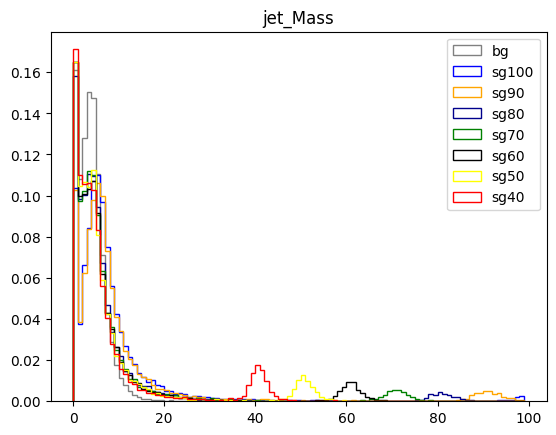

In [9]:
soon_drawvs(sg40_events,sg50_events,sg60_events,sg70_events,sg80_events,sg90_events,sg100_events,bg_events,20,0,100,1)  #16 mis_eta??

In [7]:

sg50_aal=soon_sl(sg50_events)
sg80_aal=soon_sl(sg80_events)
sg100_aal=soon_sl(sg100_events)
bg_aal=soon_sl(bg_events)
soon_drawvs(sg10_aal,sg50_aal,sg80_aal,sg100_aal,bg_aal,20,0,120,1)

NameError: name 'sg10_aal' is not defined

In [ ]:
soon_drow_m(sg10_events,sg50_events,sg80_events,sg100_events,bg_events)

In [ ]:
soon_drow_ma(sg10_events,sg50_events,sg80_events,sg100_events,bg_events)

In [ ]:
c=num_sl(sg100_events,8,2)
d=l_sl(c)
prlen(d)

e=soon_sl(sg100_events)
prlen(e)

In [ ]:
def prallsl(sg_events,sgsl_1j_Eho_1l):

    prlen(sg_events)

    sgsl_1j = j_sl(sg_events)
    prlen(sgsl_1j)

    sgEho_1j = []
    sgsl_1j = j_sl(sg_events)
    sgsl_1j_Eho = Ehover(sgsl_1j,sgEho_1j)

    prlen(sgsl_1j_Eho)

    sgsl_1j_Eho_1l = l_sl(sgsl_1j_Eho)

    prlen(sgsl_1j_Eho_1l)

In [ ]:
sgsl_1j_Eho_1l=[]

prallsl(sg10_events,sgsl_1j_Eho_1l)

bgsl_1j_Eho_1l=[]
print('')
prallsl(bg_events,bgsl_1j_Eho_1l)

In [ ]:
soon_draw(sg100_events,9,0,100,1)

In [ ]:
m10=[]
m100=[]
pt10=[]
pt100=[]
m_aa(sg10_eventsaa,m10,pt10)
m_aa(sg100_eventsaa,m100,pt100)

plt.figure(1)
bins = np.arange(0,150,1)
plt.hist([m10,m100], bins=bins, label=['10','100'], histtype='step')
plt.legend()
plt.show

plt.figure(2)
bins = np.arange(0,20,0.1)
plt.hist(m10, bins=bins, histtype='step')
plt.legend()
plt.show

In [ ]:
sgEho_1j = []
sgsl_1j = j_sl(sg10_events)
sgsl_1j_Eho = Ehover(sgsl_1j,sgEho_1j)

where = []
for i in range(len(sgsl_1j_Eho)) :
    where1 = np.where(sgsl_1j_Eho[i][20]==np.min(sgsl_1j_Eho[i][20]))
  
    where.append(where1)
   
for i in range(len(sgsl_1j_Eho)):
    print(sgsl_1j_Eho[i][20][where[i]][0])

In [ ]:
sg10_file["Delphes;1"].show()